# Model selection
Perhaps we do not know the number of segments in a rating or that a power law is better than another type of model.
In these situations, we want to compare the performance of one model against another, 
then select whichever models gives the best fit for the data.
More specifically, we want to know the generalization performance of each model,
which refers to their performance on new (out-of-sample) data.

One way to estimate generalization performance is cross validation, but it can be costly.
In cross validation, a portion of the data is held out. 
If you don't have a lot of data to begin with,
holding out a portion can substantially degrade model fit.

An alternative approach is to use information criteria,
which are measures that use in-sample data to estimate out-of-sample performance.

In this tutorial, we demonstrate how to select the number of segments in the Green River rating.
We fit the rating with 1, 2, 3, and 4 segments, then use information criteria to select the number of segments that gives the best fit.

In [1]:
## Load the data
from ratingcurve import data
%load_ext autoreload
%autoreload 2
%xmode minimal
#suppress warnings and errors

import pymc as pm
import arviz as az
from ratingcurve.ratingmodel import PowerLawRating

from ratingcurve import data

df = data.load('green channel')

Exception reporting mode: Minimal


## Fit the data
Fit the data to ratings with 1 to 4 segments.

In [2]:
%%capture
# Output supressed, this will print "Finished" after running each of the four models

segments = [1, 2, 3, 4]
traces = []
for segment in segments:
    powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'], 
                             q_sigma=df['q_sigma'],
                             segments=segment,
                             prior={'distribution':'uniform'})
    
    trace = powerrating.fit(n=100_000)
    traces.append(pm.compute_log_likelihood(trace, model=powerrating)) # Add arg to compute log likelihood

Convergence achieved at 38300
Interrupted at 38,299 [38%]: Average Loss = 217.19
Finished [100%]: Average Loss = -51.645
Finished [100%]: Average Loss = -48.277
Finished [100%]: Average Loss = -44.102


Now use `arviz.compare` to format the output.

In [3]:
# this model will generate warnings about the LOO
import warnings; warnings.filterwarnings('ignore')

compare_dict = {f'{i} segment': traces[i-1] for i in segments}
az.compare(compare_dict, ic='LOO')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
2 segment,0,72.908607,5.738289,0.000000,1.000000e+00,2.982317,0.000000,True,log
3 segment,1,62.747861,16.361458,10.160746,0.000000e+00,9.498267,9.237113,True,log
1 segment,2,52.864240,3.492606,20.044367,4.174439e-14,3.150229,3.928276,False,log
4 segment,3,42.990670,35.613225,29.917938,9.769963e-15,20.768842,20.807463,True,log


As expected, the 2-segment model ranked highest.

## Residual analysis
In practice, it can be helpful to plot to rating error
(the deviations between the rating fit and the discharge observations).
Here is a demonstration of how.

In [4]:
segments = 2
powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'], 
                             q_sigma=df['q_sigma'],
                             segments=segments,
                             prior={'distribution':'uniform'})

trace = powerrating.fit(method='advi')

Finished [100%]: Average Loss = -51.818


ValueError: operands could not be broadcast together with shapes (36,) (36,10000) 

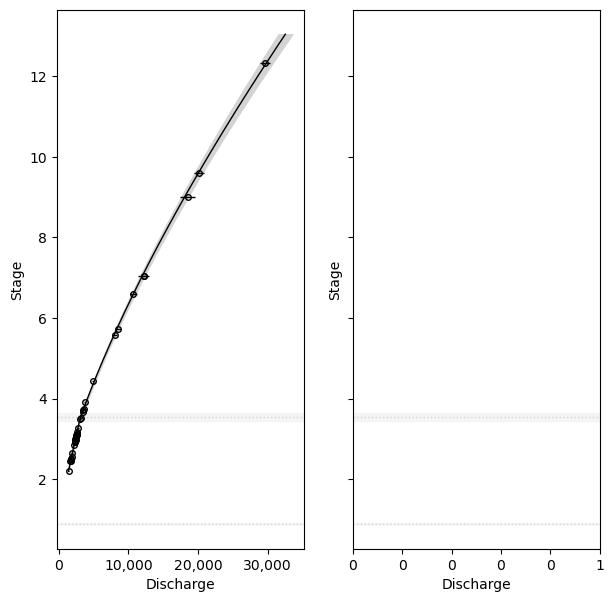

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(7,7), sharey=True)

powerrating.plot(trace, ax[0])
powerrating.plot_residuals(trace, ax[1])


plt.subplots_adjust(wspace=0.1)
ax[1].set_ylabel('')

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray